# Customer Segmentation (Cluster Analysis)

Here we will be pretend we are an owner of a store and we are trying to segment our customers into discrete groups so that we can develop unique marketing strategies for each segment.  The dataset comes from https://www.kaggle.com/datasets/dev0914sharma/customer-clustering.  It contains the sex, marital status, age, education, income, occupation, and settlement size (how much they spend) for each customer.  It contains data for 2000 customers.  From a business perspective, our goal will be to separate our data into 8 to 10 clusters.  We will be using KMeans clustering, agglomerative clustering, and DBSCAN.

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
import kneed
from sklearn.cluster import DBSCAN
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv("segmentation data.csv")

In [4]:
data.head()

ID  Sex  Marital status  Age  Education  Income  Occupation  \
0  100000001    0               0   67          2  124670           1   
1  100000002    1               1   22          1  150773           1   
2  100000003    0               0   49          1   89210           0   
3  100000004    0               0   45          1  171565           1   
4  100000005    0               0   53          1  149031           1   

   Settlement size  
0                2  
1                2  
2                0  
3                1  
4                1

We will drop the ID column because each customer has a unique ID, and each ID is essentially irrelevant for clustering purposes.

In [5]:
data=data.drop("ID", axis=1)

We can use .describe() to get an overview of the distribution of the features within our data.

In [6]:
data.describe()

Sex  Marital status          Age   Education         Income  \
count  2000.000000     2000.000000  2000.000000  2000.00000    2000.000000   
mean      0.457000        0.496500    35.909000     1.03800  120954.419000   
std       0.498272        0.500113    11.719402     0.59978   38108.824679   
min       0.000000        0.000000    18.000000     0.00000   35832.000000   
25%       0.000000        0.000000    27.000000     1.00000   97663.250000   
50%       0.000000        0.000000    33.000000     1.00000  115548.500000   
75%       1.000000        1.000000    42.000000     1.00000  138072.250000   
max       1.000000        1.000000    76.000000     3.00000  309364.000000   

        Occupation  Settlement size  
count  2000.000000      2000.000000  
mean      0.810500         0.739000  
std       0.638587         0.812533  
min       0.000000         0.000000  
25%       0.000000         0.000000  
50%       1.000000         1.000000  
75%       1.000000         1.000000  
max       2.000000         2.000000

Some things that pop out from our data:

-We have 2000 instances of our data.  This may lead to some issue with successful clustering because this a very small dataset.<br>
-We have slightly more female customers than male customers (a sex of 1 is male, 0 is female).<br> 
-About half of our customers are married, and half are not (a marital status of 1 is married, 0 is non-married).<br>
-The average age of our customers is 35.9 years old, ranging from 18 to 76.<br>
-The average income is 120,954, ranging from 35,832 to 309,364.

Another thing to notice is that we have differing numerical units like those for age and income.  For that reason, we must scale our data.  We will scale it using StandardScaler().

In [7]:
ss=StandardScaler()

In [8]:
ss.fit(data)

StandardScaler()

In [9]:
data_scaled=ss.transform(data)

## KMeans Clustering

Our first clustering method will be KMeans clustering.  As stated before, our target will be to have between 8 to 10 clusters.  We will be using the silhouette score to evaluate the sucess of our clustering.  Although our target is 8 to 10 clusters, we will be testing 2 to 12 clusters, just to see how our score varies.

In [10]:
inertia=[]
for i in range(2,13):
    kmeans=KMeans(n_clusters=i,random_state=1)
    kmeans.fit(data_scaled)
    clusters=kmeans.predict(data_scaled)
    score=silhouette_score(data_scaled,clusters)
    print(f"Silhouette Score for {i} clusters: {score}")
    inertia.append(kmeans.inertia_)

Silhouette Score for 2 clusters: 0.2508953796953238
Silhouette Score for 3 clusters: 0.27177060998494357
Silhouette Score for 4 clusters: 0.26863668715598654
Silhouette Score for 5 clusters: 0.2540800397305643
Silhouette Score for 6 clusters: 0.2630752333415311
Silhouette Score for 7 clusters: 0.27115098599206694
Silhouette Score for 8 clusters: 0.2808312241054278
Silhouette Score for 9 clusters: 0.30110993917921464
Silhouette Score for 10 clusters: 0.31015233141794374
Silhouette Score for 11 clusters: 0.3152864670394875
Silhouette Score for 12 clusters: 0.3246106084956797


As we can see, there is a positive correlation between the number of clusters and the silhouette score.  We can use the elbow method to evaluate our various clusters.

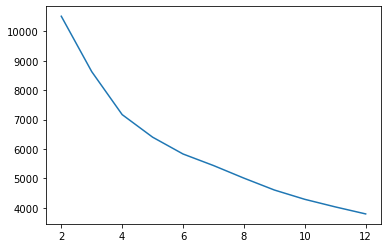

In [11]:
plt.plot(range(2,13),inertia)

Because there are only 11 points, it is difficult to visually get an accurate elbow, so we can use the kneed.KneeLocator() method to search for our elbow. 

In [12]:
knee_location=kneed.KneeLocator(range(len(inertia)), inertia, curve="convex" )
knee_location.elbow

10

Our locator found the elbow at 10, so we will be using 10 clusters for the KMeans clustering.

In [13]:
kmeans=KMeans(n_clusters=10,random_state=1)
kmeans.fit(data_scaled)
clusters=kmeans.predict(data_scaled)
print(f"Silhouette Score for {10} clusters: {score}")

Silhouette Score for 10 clusters: 0.3246106084956797


We can now visualize our clusters.  For example, let's see how age and income vary by cluster.

<AxesSubplot:xlabel='Age', ylabel='Income'>

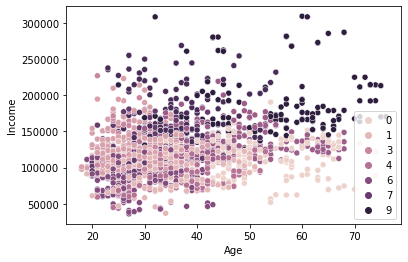

In [14]:
sns.scatterplot(data["Age"],data["Income"], hue=clusters)

As we can see, visualizing all 10 clusters for each combinations of features can get messy.  We can clean this up by reducing dimensionality with principal component analysis (PCA).  We will use 90% of our data for the PCA.

In [15]:
pca=PCA(0.90)
X_pca=pca.fit_transform(data_scaled)

In [16]:
X_pca.shape

(2000, 5)

We have reduced our features to 5 components.

In [17]:
X_df=pd.DataFrame(X_pca)

In [18]:
X_df.head()

0         1         2         3         4
0  2.514746  0.834122  2.174806  1.217794 -0.677176
1  0.344935  0.598146 -2.211603  0.548385 -0.706269
2 -0.651063 -0.680093  2.280419  0.120675  0.166480
3  1.714316 -0.579927  0.730731 -0.510753  0.044448
4  1.626745 -0.440496  1.244909 -0.231808 -0.094499

We can now visualize our clusters by plotting each combination of the principal components.

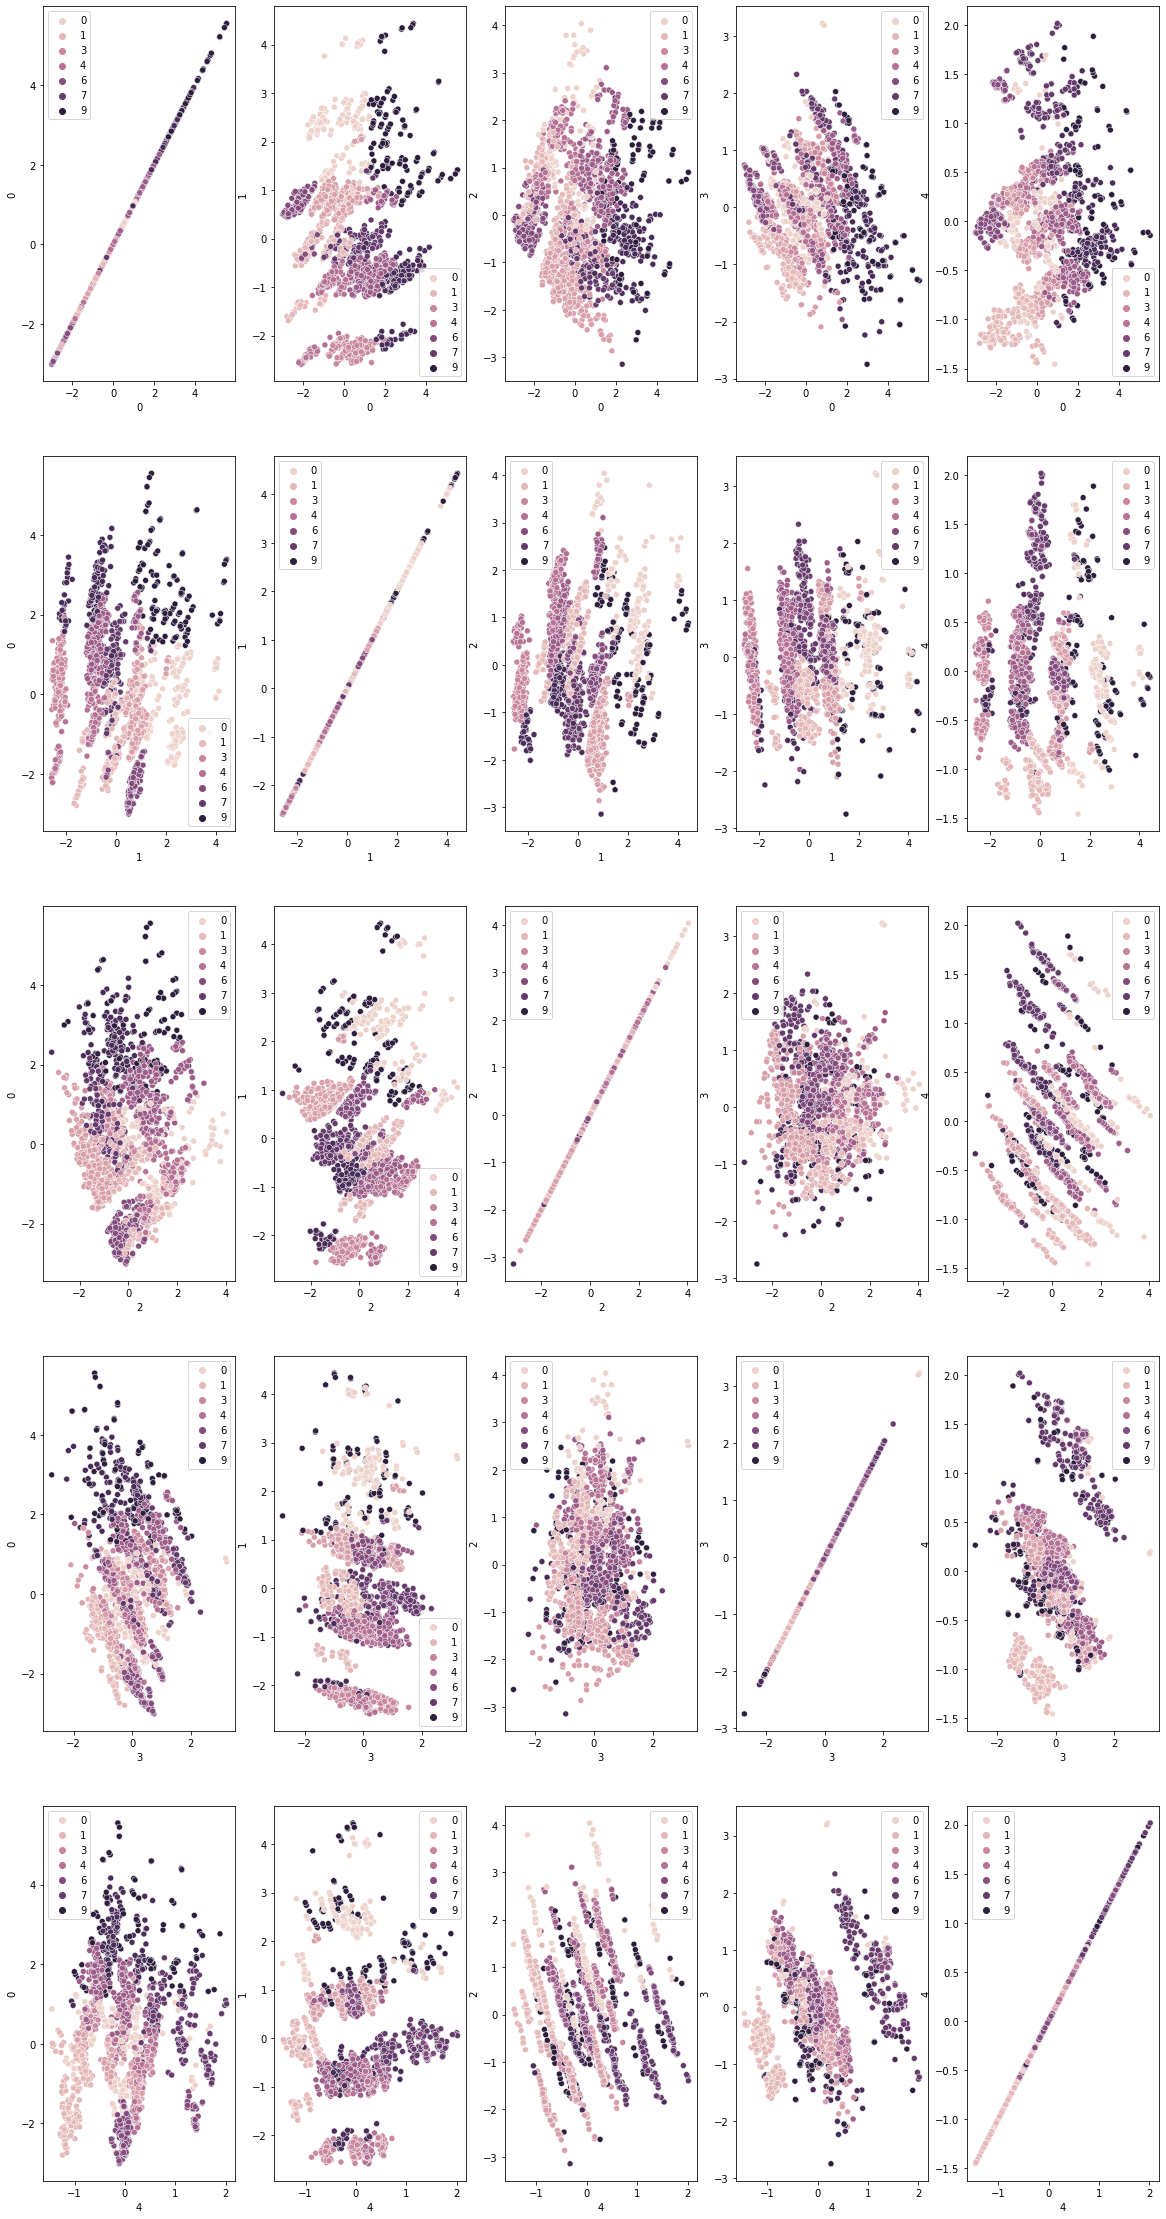

In [19]:
fig,ax=plt.subplots(5,5,figsize=(20,40))
for i in range(5):
    for j in range(5):
            sns.scatterplot(X_df[i],X_df[j],hue=clusters,ax=ax[i,j])

Now let's see how many customers are in each cluster.

In [20]:
data_clustered=data

In [21]:
data_clustered["KMeans Cluster"]=clusters

<AxesSubplot:>

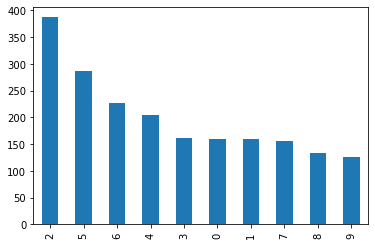

In [22]:
data_clustered['KMeans Cluster'].value_counts().plot(kind='bar')

Here we can see that cluster 2 has the most instances.  Each cluster looks like it has more than 100 instances.  Now we can view the characteristics for the customers in each cluster.  We can use the .cluster_centers_ method from our KMeans object to describe the centroid for each cluster.  We also have to un-scale the data so that we can see it in terms that are consitent with the original units. 

In [23]:
clusters=round(pd.DataFrame(ss.inverse_transform(kmeans.cluster_centers_)),2)

In [24]:
clusters.columns=['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation',
       'Settlement size']

In [25]:
clusters

Sex  Marital status    Age  Education     Income  Occupation  \
0  0.79            0.81  52.24       2.12  115042.63        0.37   
1  1.00            0.00  33.34       0.81   95701.52        0.38   
2  1.00            1.00  27.83       1.01  120005.00        1.05   
3 -0.00            0.00  27.63       0.00  123238.60        1.01   
4 -0.00           -0.00  35.12       0.68   91072.49        0.12   
5 -0.00            0.00  44.80       1.11  131985.56        0.96   
6  0.82            1.00  28.28       1.00   83866.34        0.00   
7 -0.00            1.00  29.43       1.03  122898.89        1.10   
8  0.02            0.03  36.96       0.79  173478.48        1.93   
9  0.43            0.72  55.42       2.12  191836.08        1.60   

   Settlement size  
0             0.32  
1             0.06  
2             0.76  
3             1.15  
4             0.05  
5             1.23  
6            -0.00  
7             1.10  
8             1.63  
9             1.45

As we can see, each cluster has different characteristics.  For example, cluster 1 seems to be unmarried males, and cluster 2 seems to be married males.  Cluster 9 seems to have the oldest people, as well as the highest income earners.  So we will obviously target unmarried young men much differently than we would target older married people.

## Agglomerative Clustering

The next method we will use will be agglomerative clustering.  We will try single, complete, average, and ward linkages.  We will be using dendrograms to see what the best number of clusters are for each type of linkage.

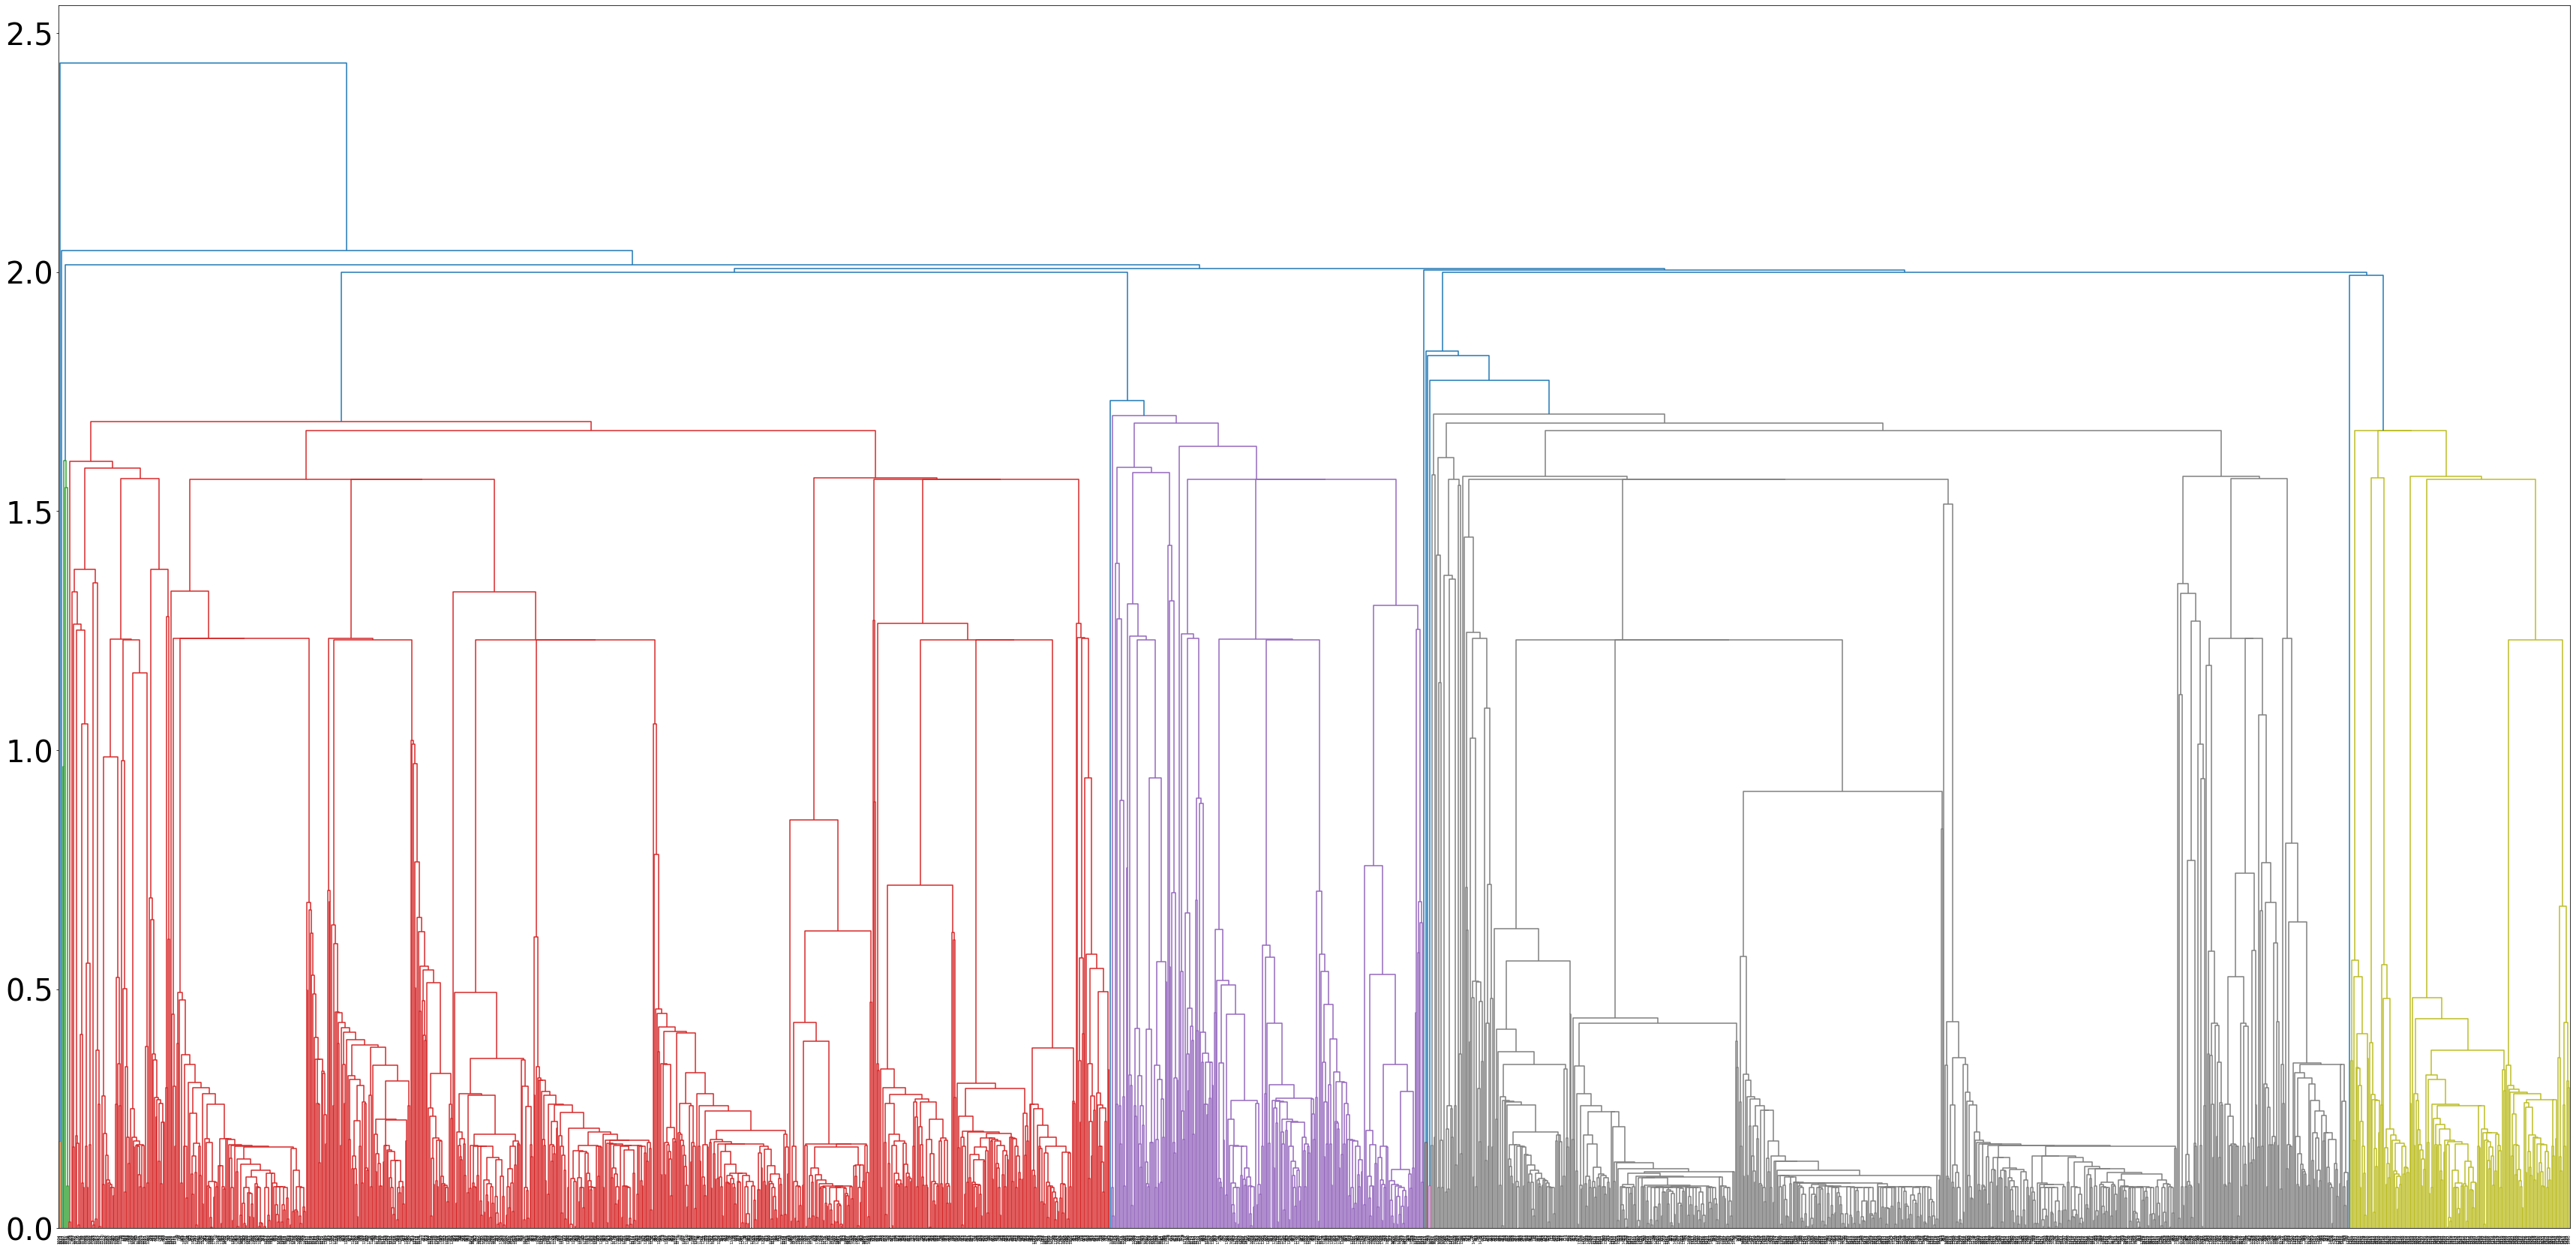

In [26]:
linkage_data=linkage(data_scaled,"single") 
plt.figure(figsize=(60, 30))
plt.yticks(fontsize=40)
dendrogram(linkage_data)
plt.show()

Single linkage is not giving us good results.  The blue line is the longest (reaching from the base to a distance of about 2.0).  It is giving many clusters, and therefore we will not be using single linkage.

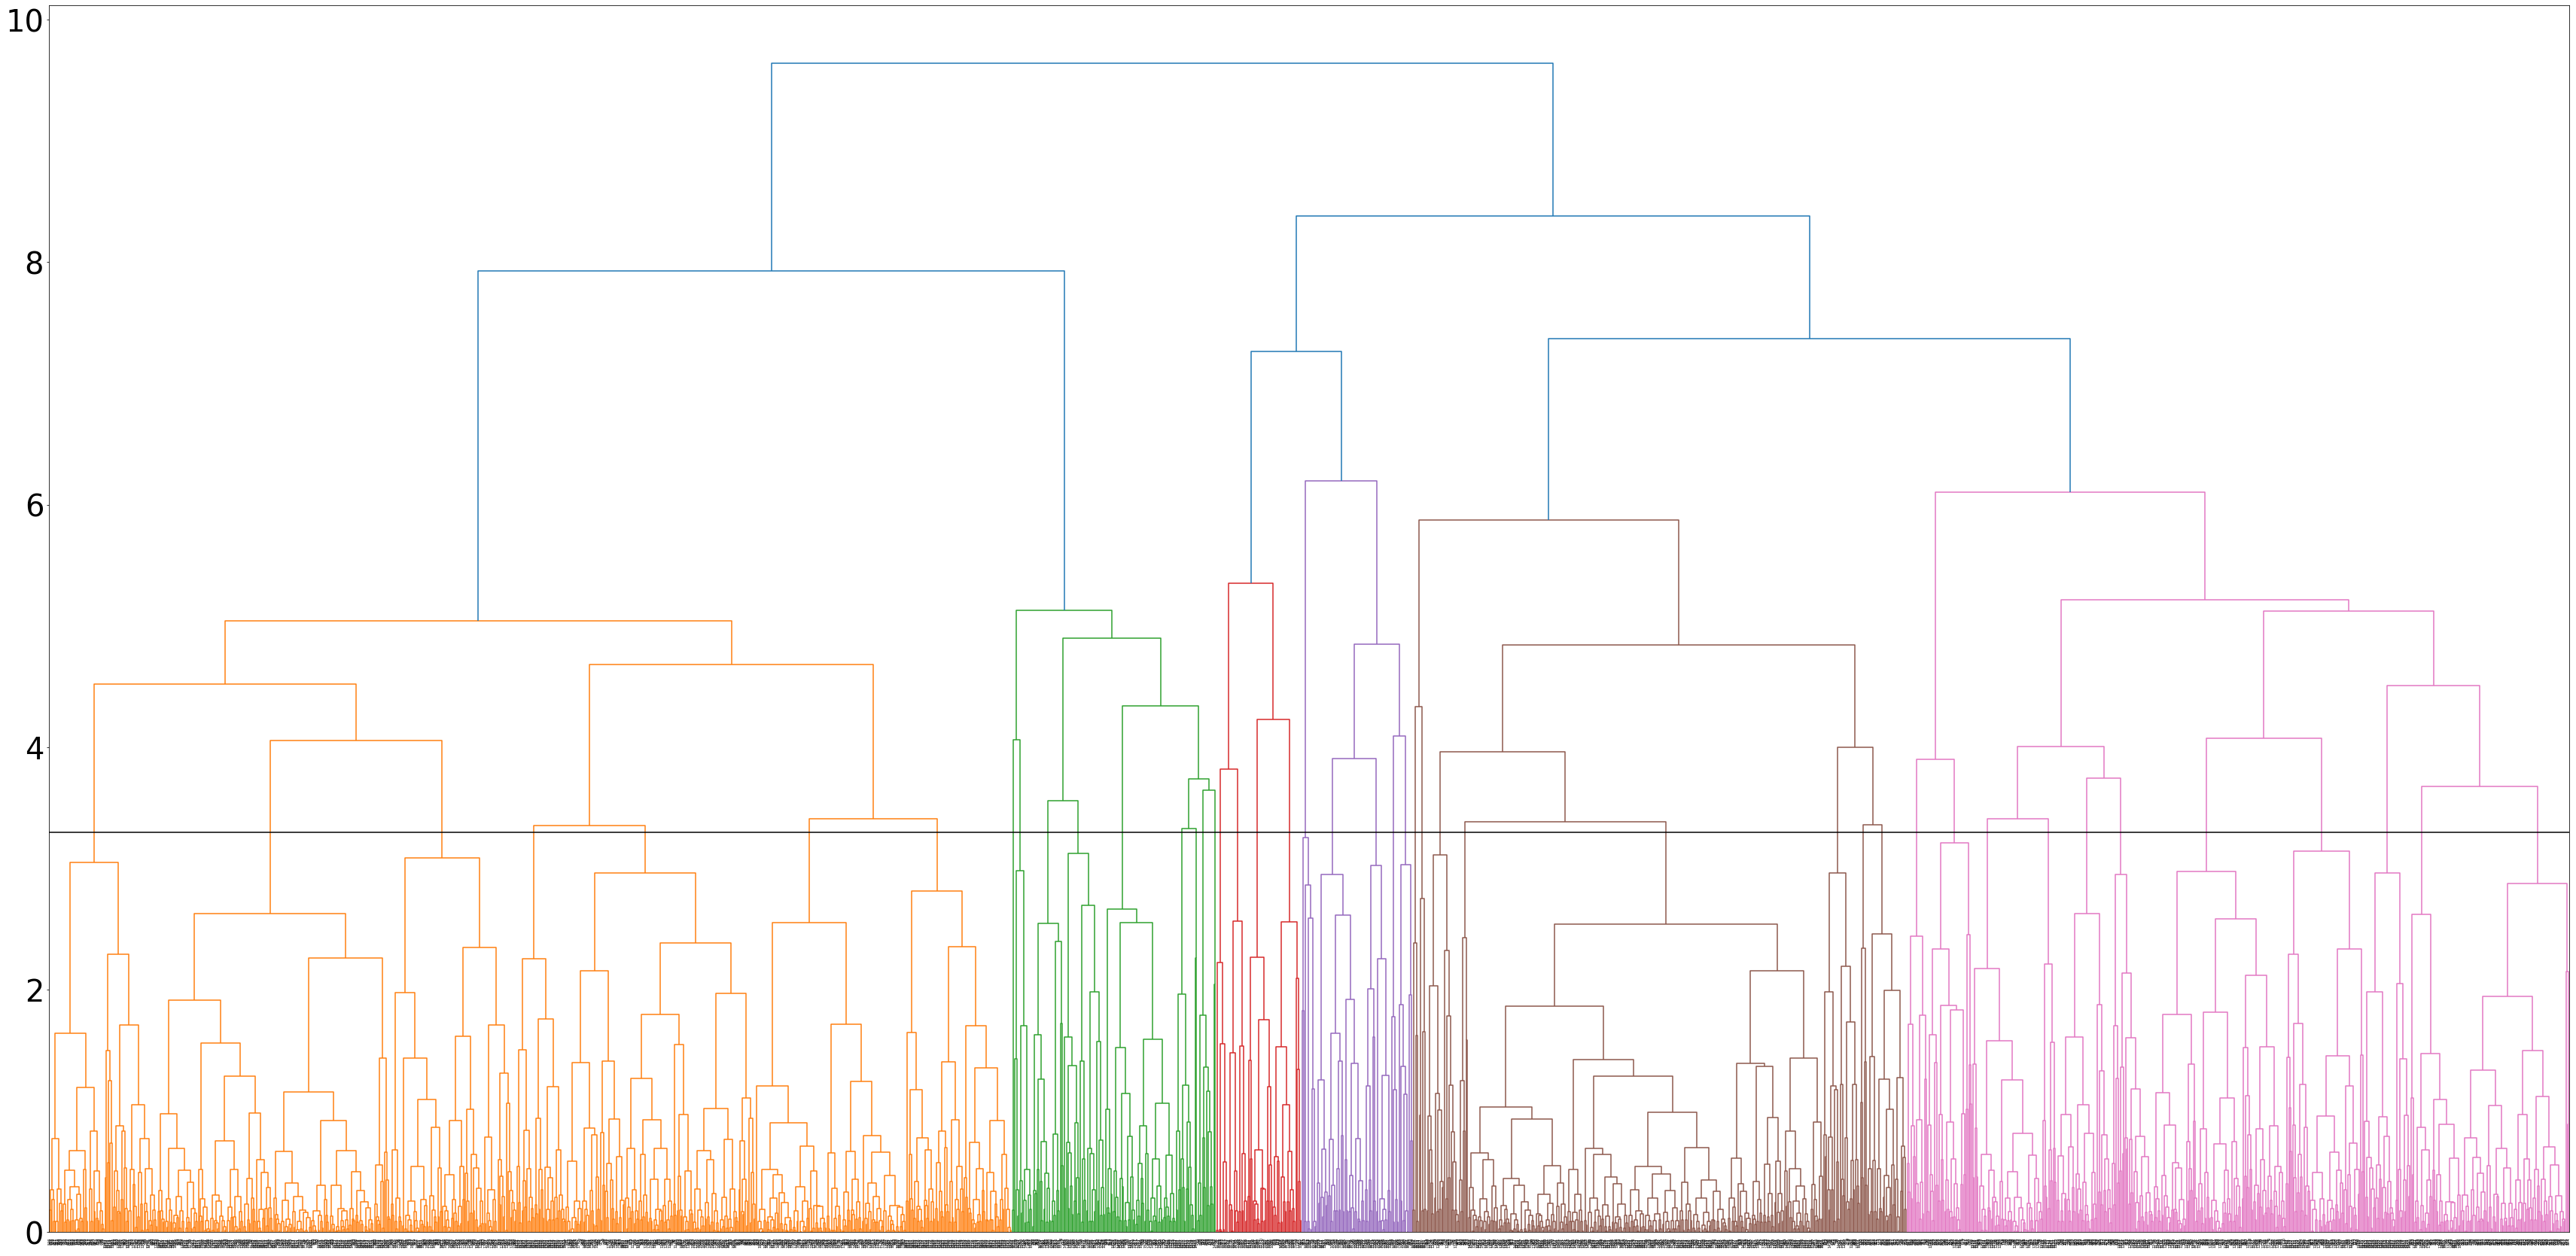

In [27]:
linkage_data=linkage(data_scaled,"complete")
plt.figure(figsize=(60, 30))
plt.yticks(fontsize=40)
dendrogram(linkage_data)
plt.axhline(y=3.3, color='k')
plt.show()

Although somewhat better than single linkage, complete linkage is also not giving us good results.  The purple line is the longest (spanning form a distance of about 3.5 to 6).  It is also giving many clusters, and therefore we will not be using complete linkage.

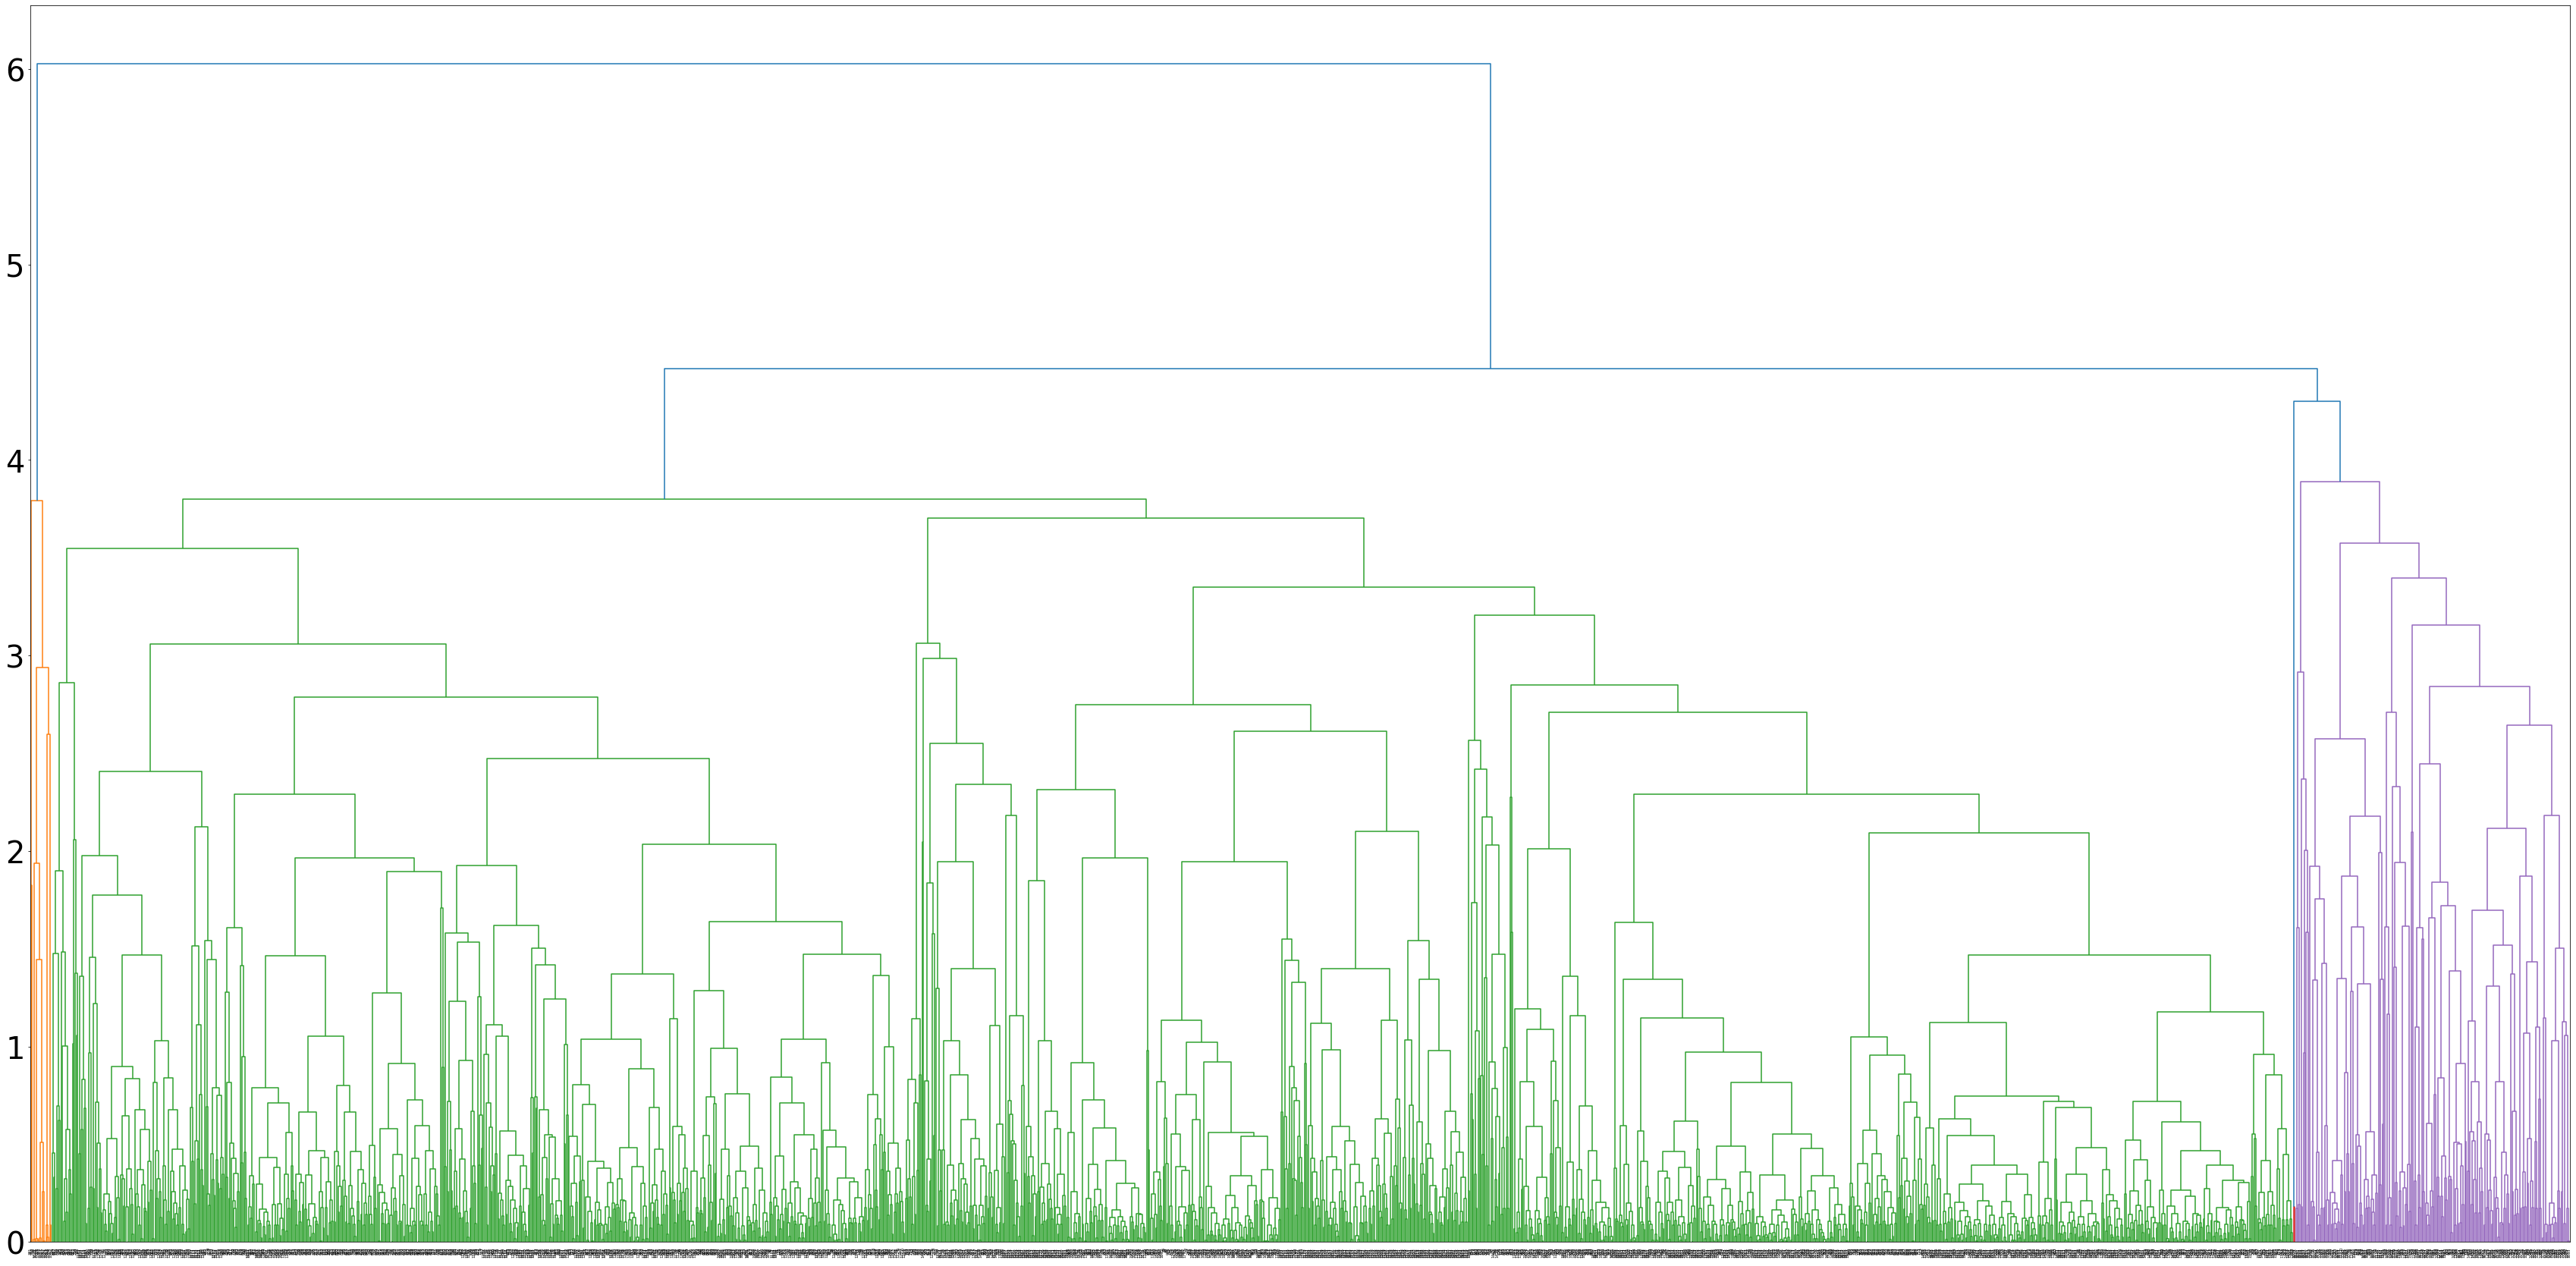

In [28]:
linkage_data=linkage(data_scaled,"average") 
plt.figure(figsize=(60, 30))
plt.yticks(fontsize=40)
dendrogram(linkage_data)
plt.show()

Average linkage is also not giving us good results.  It has a similar issue to single linkage, where the longest line (reaching from the base to a distance of about 4.3) is giving us many clusters as well.  We will also not be using average linkage.

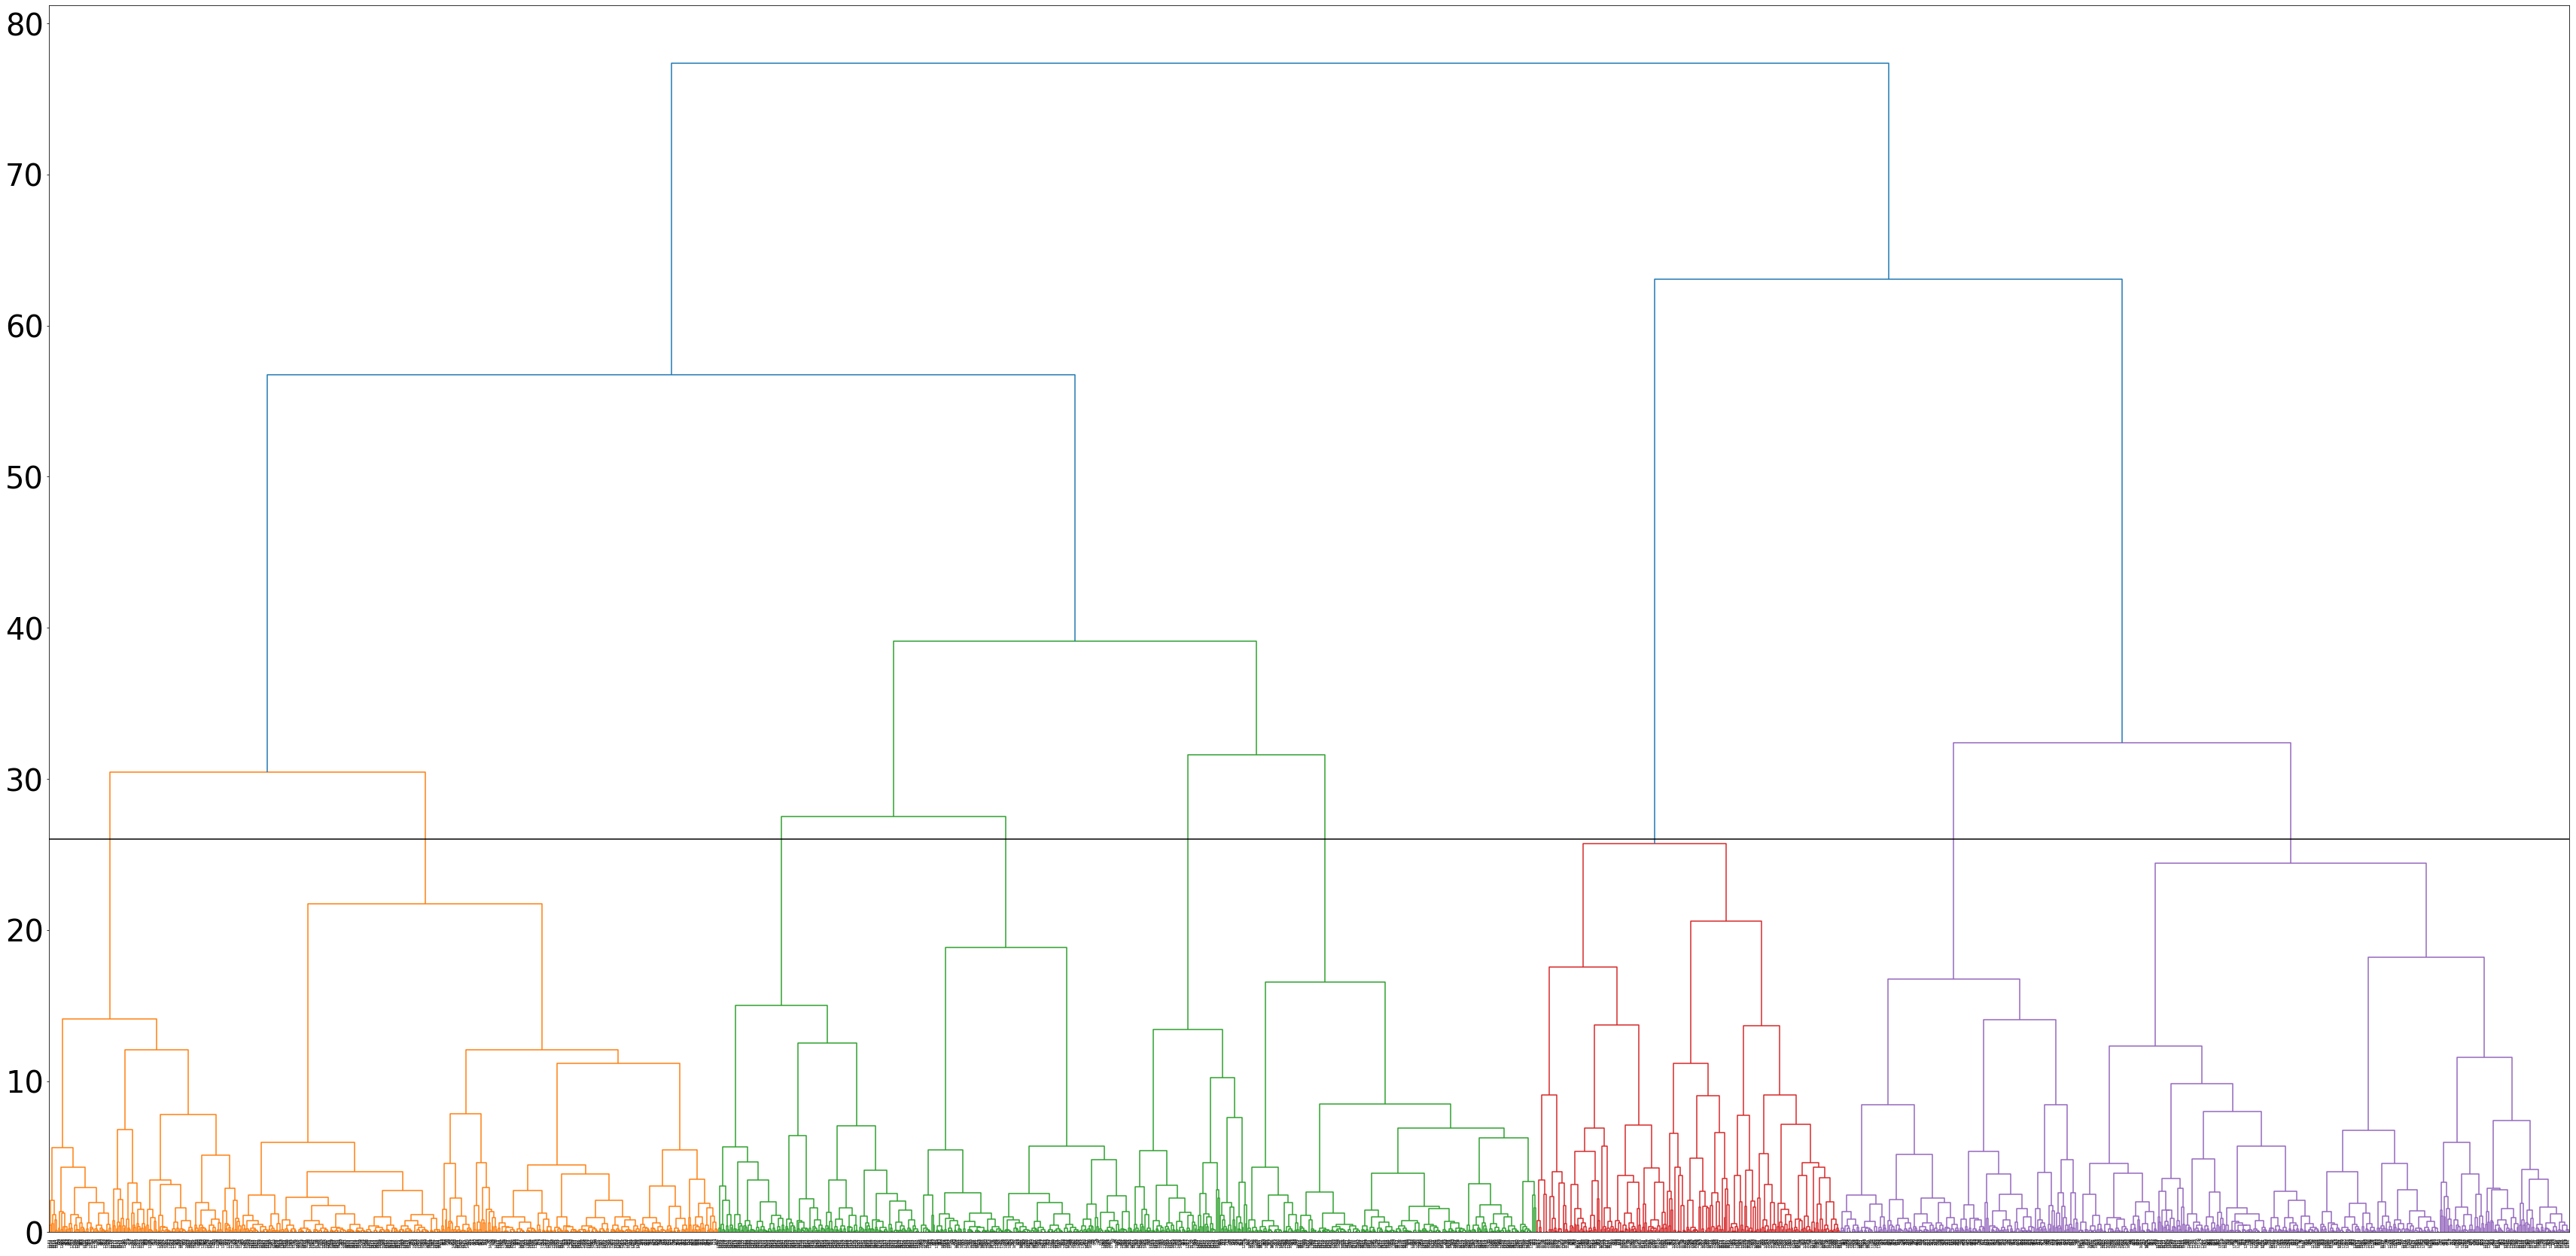

In [29]:
linkage_data=linkage(data_scaled,"ward")
plt.figure(figsize=(60, 30))
plt.yticks(fontsize=40)
dendrogram(linkage_data)
plt.axhline(y=26, color='k')
plt.show()

Ward linkage is performing the best out of all of the linkages.  The blue line spanning from about 26 to 63 is the longest.  Based on that line, we can see that we can take 9 clusters.

In [30]:
n_clusters=9

In [31]:
agg=AgglomerativeClustering(n_clusters,linkage='ward')
agg.fit(data_scaled)
clusters=agg.fit_predict(data_scaled)
score=silhouette_score(data_scaled,clusters)
print(f"Silhouette Score for {n_clusters} clusters: {score}")

Silhouette Score for 9 clusters: 0.3016137339305145


The silhouette score for 9 clusters here is 0.302.

We can look at the number of instances for each cluster like we did for the KMeans.

In [32]:
data_clustered["Agglomerative Cluster"]=clusters

<AxesSubplot:>

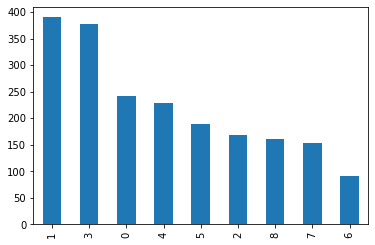

In [33]:
data_clustered["Agglomerative Cluster"].value_counts().plot(kind='bar')

We can't use cluster centroids to describe our agglomerative clustering resutls, but we can take the mean for each feature to see our clusters.

In [34]:
data_clustered.groupby("Agglomerative Cluster").agg({"Sex":"mean","Marital status":"mean","Age":"mean",\
                                                     "Education":"mean","Income":"mean","Occupation":"mean", \
                                                     "Settlement size":"mean"})

Sex  Marital status        Age  Education  \
Agglomerative Cluster                                                   
0                      0.497925        0.717842  54.593361   2.120332   
1                      0.000000        0.000000  41.161538   1.000000   
2                      0.000000        0.000000  34.976331   0.609467   
3                      1.000000        1.000000  27.679894   1.000000   
4                      0.816594        1.000000  28.318777   1.000000   
5                      0.000000        0.000000  27.841270   0.000000   
6                      0.758242        0.659341  51.945055   2.021978   
7                      0.000000        1.000000  29.006536   1.000000   
8                      1.000000        0.000000  33.262500   0.800000   

                              Income  Occupation  Settlement size  
Agglomerative Cluster                                              
0                      163924.684647    1.257261         1.219917  
1                      139404.076923    1.200000         1.246154  
2                       87222.905325    0.000000         0.000000  
3                      119136.650794    1.052910         0.743386  
4                       85057.240175    0.000000         0.004367  
5                      133170.687831    1.126984         1.243386  
6                      102534.923077    0.021978         0.021978  
7                      123519.797386    1.130719         1.091503  
8                       96153.118750    0.400000         0.075000

We can also view our agglomerative clusters on our plots with the components.

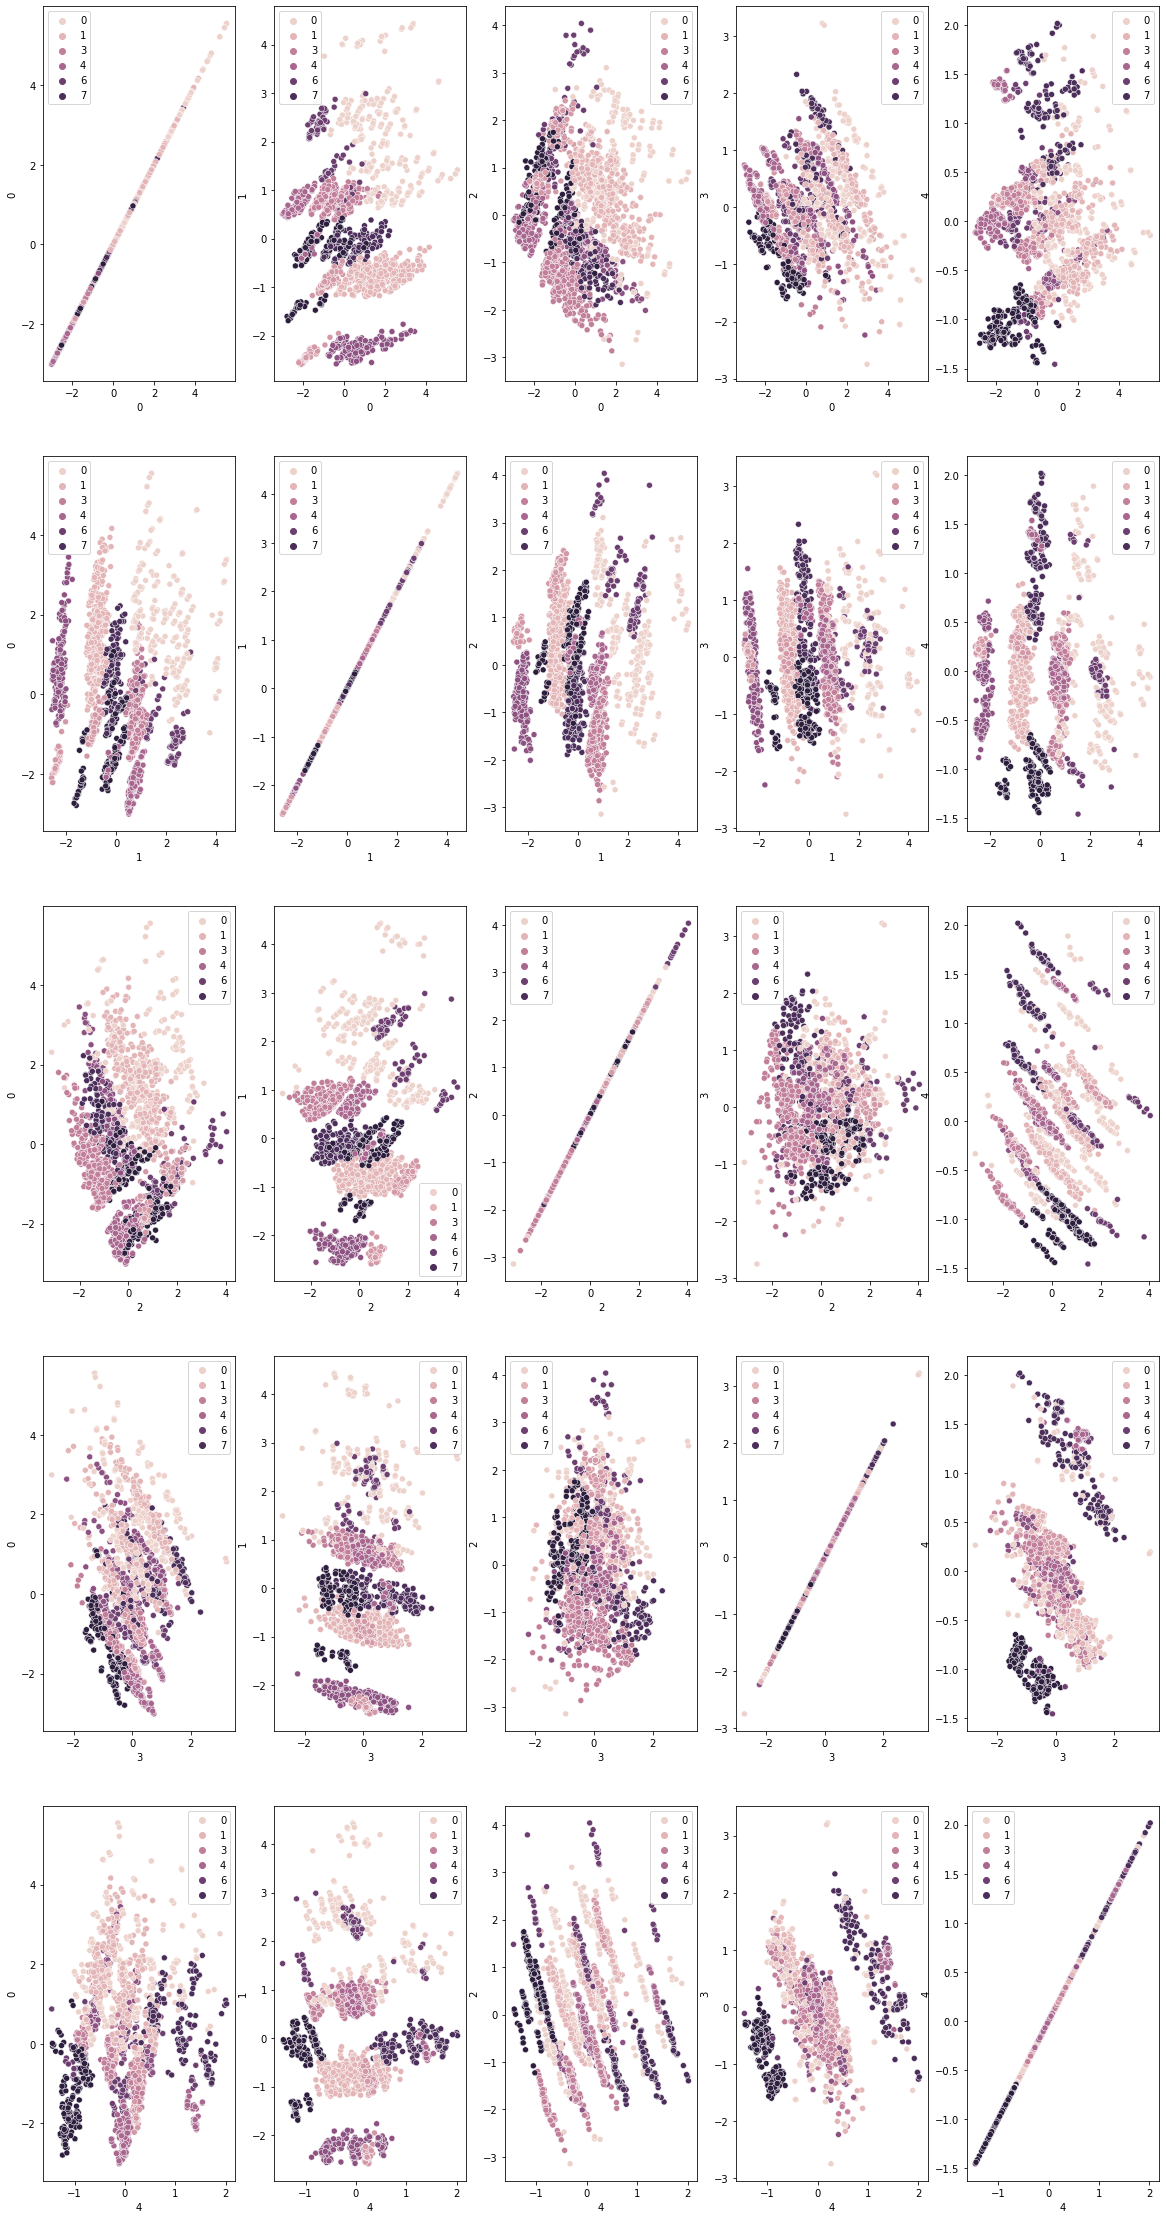

In [35]:
fig,ax=plt.subplots(5,5,figsize=(20,40))
for i in range(5):
    for j in range(5):
            sns.scatterplot(X_df[i],X_df[j],hue=clusters,ax=ax[i,j])

## DBSCAN

The final method we will be using is DBSCAN.

We will be using K-Nearest Neighbors measured by the euclidean distance to determine the epsilon parameter for the DBSCAN.  In this case, since there are 7 features in our data, we will be use 14 nearest neighbors (7 features * 2).

In [36]:
knn=NearestNeighbors(n_neighbors=14, metric='euclidean')

In [37]:
knn.fit(data_scaled)

NearestNeighbors(metric='euclidean', n_neighbors=14)

In [38]:
dist,index=knn.kneighbors()

In [39]:
dist

array([[0.09127957, 0.19890495, 0.26482631, ..., 1.25018698, 1.26121575,
        1.26381738],
       [0.18894246, 0.19214747, 0.33263111, ..., 0.70195033, 0.75492929,
        0.78372895],
       [0.08676223, 0.15247935, 0.17128585, ..., 0.42188385, 0.43628372,
        0.44638785],
       ...,
       [0.10924086, 0.17241409, 0.17760893, ..., 0.4417142 , 0.44685865,
        0.45506545],
       [0.00154859, 0.0861633 , 0.08675281, ..., 0.23627733, 0.2412985 ,
        0.24223168],
       [0.04693   , 0.07199608, 0.08546106, ..., 0.1545738 , 0.17230152,
        0.17273801]])

Here we get the distance for each data point that are the nearest neighbors.  We will get the largest distance for each point to create our elbow plot to figure out epsilon.  To do this, we can sort the distances for our 14 neighbors for each point, and take the largest distance (which will be the last distance, at the 13th element).  We can then use these distances for our elbow plot.

In [40]:
sort_dist_=np.sort(dist,axis=0)

In [41]:
sort_dist=sort_dist_[:,13]

In [42]:
sort_dist

array([0.11998558, 0.12063215, 0.12261501, ..., 3.19639192, 3.22217401,
       3.2295078 ])

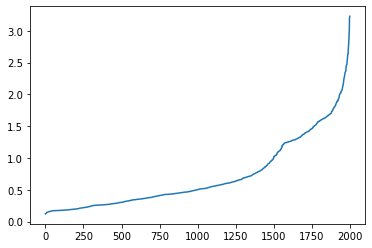

In [43]:
plt.plot(sort_dist)
plt.show()

In [44]:
knee_location=kneed.KneeLocator(range(len(sort_dist)), sort_dist, curve="convex")
knee_location.elbow_y

2.0266005565377383

The elbow is at a value of 2.03, so we will use 2.03 as our epsilon parameter for the DBSCAN.  We will also set min_sample=14 because we used 14 neighbors in the K-Nearest Neighbors.

In [45]:
dbs=DBSCAN(eps=2.03,min_samples=14,metric="euclidean")

In [46]:
dbs.fit(data_scaled)

DBSCAN(eps=2.03, min_samples=14)

In [47]:
clusters=dbs.labels_
clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
Counter(clusters)

Counter({0: 1987, -1: 13})

In [49]:
n_clusters=1
score=silhouette_score(data_scaled,clusters)
print(f"Silhouette Score for {n_clusters} cluster: {score}")

Silhouette Score for 1 cluster: 0.34676759575692034


As we can see, our model is giving us 1 cluster (cluster 0 and cluster -1, which are the outliers).  This is very poor performance.

To generate more clusters, we can lower the epsilon value.  Let's try an epsilon of 1.9.

In [50]:
dbs=DBSCAN(eps=1.9,min_samples=14,metric="euclidean")
dbs.fit(data_scaled)
clusters=dbs.labels_

In [51]:
Counter(clusters)

Counter({0: 824, 1: 727, 2: 246, -1: 28, 3: 175})

In [52]:
n_clusters=4
score=silhouette_score(data_scaled,clusters)
print(f"Silhouette Score for {n_clusters} clusters: {score}")

Silhouette Score for 4 clusters: 0.17970325785872654


An epsilon of 1.9 is a little bit better because it generates 4 clusters.  However, this is not good enough because our business goal is to find 8 to 10 clusters. Let's keep going lower. Let's try an epsilon of 1.5.

In [53]:
dbs=DBSCAN(eps=1.5,min_samples=14,metric="euclidean")
dbs.fit(data_scaled)
clusters=dbs.labels_

In [54]:
Counter(clusters)

Counter({0: 38,
         1: 358,
         2: 125,
         3: 268,
         4: 100,
         -1: 115,
         14: 27,
         16: 15,
         5: 185,
         6: 158,
         7: 119,
         8: 48,
         9: 59,
         10: 22,
         11: 66,
         12: 26,
         13: 55,
         15: 20,
         17: 32,
         18: 75,
         20: 15,
         19: 51,
         21: 23})

In [55]:
n_clusters=22
score=silhouette_score(data_scaled,clusters)
print(f"Silhouette Score for {n_clusters} clusters: {score}")

Silhouette Score for 22 clusters: 0.3432894427532215


An epsilon of 1.5 yields 22 clusters.  Although the silhouette score for 22 clusters is better than that of 4 clusters, this is still not good because 22 clusters exceeds our 8 to 10 cluster range.  Let's try an epsilon of 1.6. 

In [56]:
dbs=DBSCAN(eps=1.6,min_samples=14,metric="euclidean")
dbs.fit(data_scaled)
clusters=dbs.labels_

In [57]:
Counter(clusters)

Counter({0: 55,
         1: 568,
         2: 493,
         -1: 78,
         4: 194,
         3: 254,
         5: 134,
         7: 15,
         6: 36,
         8: 128,
         9: 15,
         10: 30})

In [58]:
n_clusters=11
score=silhouette_score(data_scaled,clusters)
print(f"Silhouette Score for {n_clusters} clusters: {score}")

Silhouette Score for 11 clusters: 0.22316434895913778


An epsilon of 1.6 is good because it gives us 11 clusters.  However, this is not within our target 8 to 10 cluster range.  We can lower this by manually adding some very close clusters.  To do this, we can use K-Nearest Neighbors to find our nearest clusters.  First, let's look at our current clusters by using the same aggregation technique as we did with agglomerative clustering.

In [59]:
data_clustered["DBSCAN Cluster"]=clusters

In [60]:
dbscan_results=data_clustered.groupby("DBSCAN Cluster").agg({"Sex":"mean","Marital status":"mean","Age":"mean",\
                                                     "Education":"mean","Income":"mean","Occupation":"mean", \
                                                     "Settlement size":"mean"})

In [61]:
dbscan_results

Sex  Marital status        Age  Education         Income  \
DBSCAN Cluster                                                             
-1              0.5        0.782051  52.974359   2.346154  182276.230769   
 0              0.0        0.000000  63.381818   2.000000  130364.763636   
 1              1.0        1.000000  27.786972   1.000000  108911.554577   
 2              0.0        0.000000  41.036511   1.000000  129712.182556   
 3              0.0        0.000000  27.421260   0.000000  118422.696850   
 4              0.0        1.000000  29.082474   1.000000  113616.592784   
 5              1.0        1.000000  50.007463   2.000000  132652.223881   
 6              0.0        1.000000  51.611111   2.000000  142504.888889   
 7              0.0        0.000000  67.466667   2.000000  184378.200000   
 8              1.0        0.000000  34.773438   1.000000   99135.445312   
 9              1.0        0.000000  49.400000   2.000000  116317.333333   
 10             1.0        0.000000  27.200000   0.000000   82834.433333   

                Occupation  Settlement size  
DBSCAN Cluster                               
-1                1.294872         1.076923  
 0                0.690909         0.963636  
 1                0.711268         0.503521  
 2                0.949290         0.985801  
 3                0.830709         0.921260  
 4                0.891753         0.860825  
 5                0.738806         0.731343  
 6                0.972222         1.083333  
 7                2.000000         1.266667  
 8                0.429688         0.093750  
 9                0.000000         0.000000  
 10               0.233333         0.000000

To do the K-Nearest Neighbors, we have to scale the data because it is in its original units.  We will be taking the number of neighbors to be 11, because there are 12 instances (11 clusters, 1 outlier cluster) and this is the max number we can use.

In [62]:
ss.fit(dbscan_results)
dbscan_results_scaled=ss.transform(dbscan_results)

In [63]:
knn=NearestNeighbors(n_neighbors=11, metric='euclidean')
knn.fit(dbscan_results_scaled)

NearestNeighbors(metric='euclidean', n_neighbors=11)

In [64]:
dist,index=knn.kneighbors()

In [65]:
dist[0],index[0]-1

(array([1.9610938 , 2.53755417, 2.72118742, 3.06646467, 3.37936128,
        3.72959297, 4.16108058, 4.72305213, 4.74989256, 5.01900606,
        6.26602504]),
 array([ 6,  5,  7,  0,  2,  4,  1,  3,  9,  8, 10], dtype=int64))

Here we can see the distances to each neighboring cluster for cluster -1.  dist[0] is giving us the distances for cluster -1. index[0]-1 is giving us the clusters labels that are corresponding to each distance (we add the -1 because of KNN takes the -1 cluster to be the 0 index, so we do this so that we can see the proper cluster number).  As we can see here, 1.961094 is the smallest distance, and it corresponds to cluster 6.  This means that cluster 6 is the closest cluster to cluster -1, with a distance of 1.961094.

It will be very tedious to do this for each cluster, so we can get the minimum distance and its corresponding cluster by using the get_closest_clusters() function:

In [66]:
def get_closest_clusters(num):
    merged=pd.DataFrame(dist[num+1]).merge(pd.DataFrame(index[num+1]-1), left_index=True, right_index=True)
    x=merged[merged['0_x']==merged['0_x'].min()]
    x.columns=['distance','cluster b']
    x.insert(1, 'cluster a', num)
    return x

In [67]:
get_closest_clusters(-1)

distance  cluster a  cluster b
0  1.961094         -1          6

As we can see, cluster 6 is the closest to cluster -1.  Now we can loop through each cluster to see which clusters are closest.

In [68]:
df=pd.DataFrame(columns=['distance', 'cluster a', 'cluster b'])

In [69]:
for i in range(-1, 11):
    df=pd.concat([df, get_closest_clusters(i)])

In [70]:
df.sort_values('distance')

distance cluster a cluster b
0  1.577525         8        10
0  1.577525        10         8
0  1.695405         2         3
0  1.695405         3         2
0  1.961094        -1         6
0  1.961094         6        -1
0  1.991355         9         8
0  2.141862         0         2
0  2.287528         1         5
0  2.287528         5         1
0  2.293025         4         1
0  2.721187         7        -1

As we can see, clusters 8 and 10 have the shortest distance between the two (1.578), so we could possibly merge them. The second shortest distance is between clusters 2 and 3 (1.695), and the third shortest distance is between clusters 6 and -1 (1.961).  The degree to which we merge clusters is based on the discretion of the practitioner, but prior to merging, I am just going to look at the value counts for each cluster again. 

In [71]:
Counter(clusters)

Counter({0: 55,
         1: 568,
         2: 493,
         -1: 78,
         4: 194,
         3: 254,
         5: 134,
         7: 15,
         6: 36,
         8: 128,
         9: 15,
         10: 30})

There are 128 values in cluster 8, and 30 values in cluster 10.  If we were to merge them, we would get a cluster with 158 values, which is reasonable for our current cluster distribution.  Therefore, we will be merging cluster 8 and cluster 10.

There are 493 values in cluster 2, and 254 values in cluster 3.  If we were to merge them, we would get a cluster with 747 values.  This would be a very large cluster, and although the distances are short between the two (1.695), I will be keeping these clusters separate.  This is completely based on my discretion, as I do not want such an imbalance in size of clusters.

There are 78 values in cluster -1, and 36 values in cluster 6.  Merging them will give us a cluster with 114 values.  This is a reasonable amount, and the distance between the two is still relatively small (1.961) so we will be merging these as well.

To merge these clusters, we can use the merge_clusters() function.  We will be converting and appending cluster 10 to cluster 8, and converting and appending cluster 6 to cluster -1.

In [72]:
def merge_clusters(data):
    if data==10:
        return 8
    elif data==6:
        return -1
    else:
        return data

In [73]:
data_clustered["Modified DBSCAN Cluster"]=data_clustered["DBSCAN Cluster"].apply(lambda x: merge_clusters(x))

In [74]:
clusters=data_clustered["Modified DBSCAN Cluster"].values

In [75]:
Counter(clusters)

Counter({0: 55,
         1: 568,
         2: 493,
         -1: 114,
         4: 194,
         3: 254,
         5: 134,
         7: 15,
         8: 158,
         9: 15})

Here we can see the updated value counts for each cluster.  We now have 9 main clusters, and 1 outlier cluster.  This falls within our 8 to 10 cluster target range.  Again, we can view our clusters by aggregating the features by their means, and we can also visualize them on our plots with the components.

In [76]:
dbscan_results=data_clustered.groupby("Modified DBSCAN Cluster").agg({"Sex":"mean","Marital status":"mean","Age":"mean",\
                                                     "Education":"mean","Income":"mean","Occupation":"mean", \
                                                     "Settlement size":"mean"})

In [77]:
dbscan_results

Sex  Marital status        Age  Education  \
Modified DBSCAN Cluster                                                   
-1                       0.342105        0.850877  52.543860   2.236842   
 0                       0.000000        0.000000  63.381818   2.000000   
 1                       1.000000        1.000000  27.786972   1.000000   
 2                       0.000000        0.000000  41.036511   1.000000   
 3                       0.000000        0.000000  27.421260   0.000000   
 4                       0.000000        1.000000  29.082474   1.000000   
 5                       1.000000        1.000000  50.007463   2.000000   
 7                       0.000000        0.000000  67.466667   2.000000   
 8                       1.000000        0.000000  33.335443   0.810127   
 9                       1.000000        0.000000  49.400000   2.000000   

                                Income  Occupation  Settlement size  
Modified DBSCAN Cluster                                              
-1                       169716.859649    1.192982         1.078947  
 0                       130364.763636    0.690909         0.963636  
 1                       108911.554577    0.711268         0.503521  
 2                       129712.182556    0.949290         0.985801  
 3                       118422.696850    0.830709         0.921260  
 4                       113616.592784    0.891753         0.860825  
 5                       132652.223881    0.738806         0.731343  
 7                       184378.200000    2.000000         1.266667  
 8                        96040.316456    0.392405         0.075949  
 9                       116317.333333    0.000000         0.000000

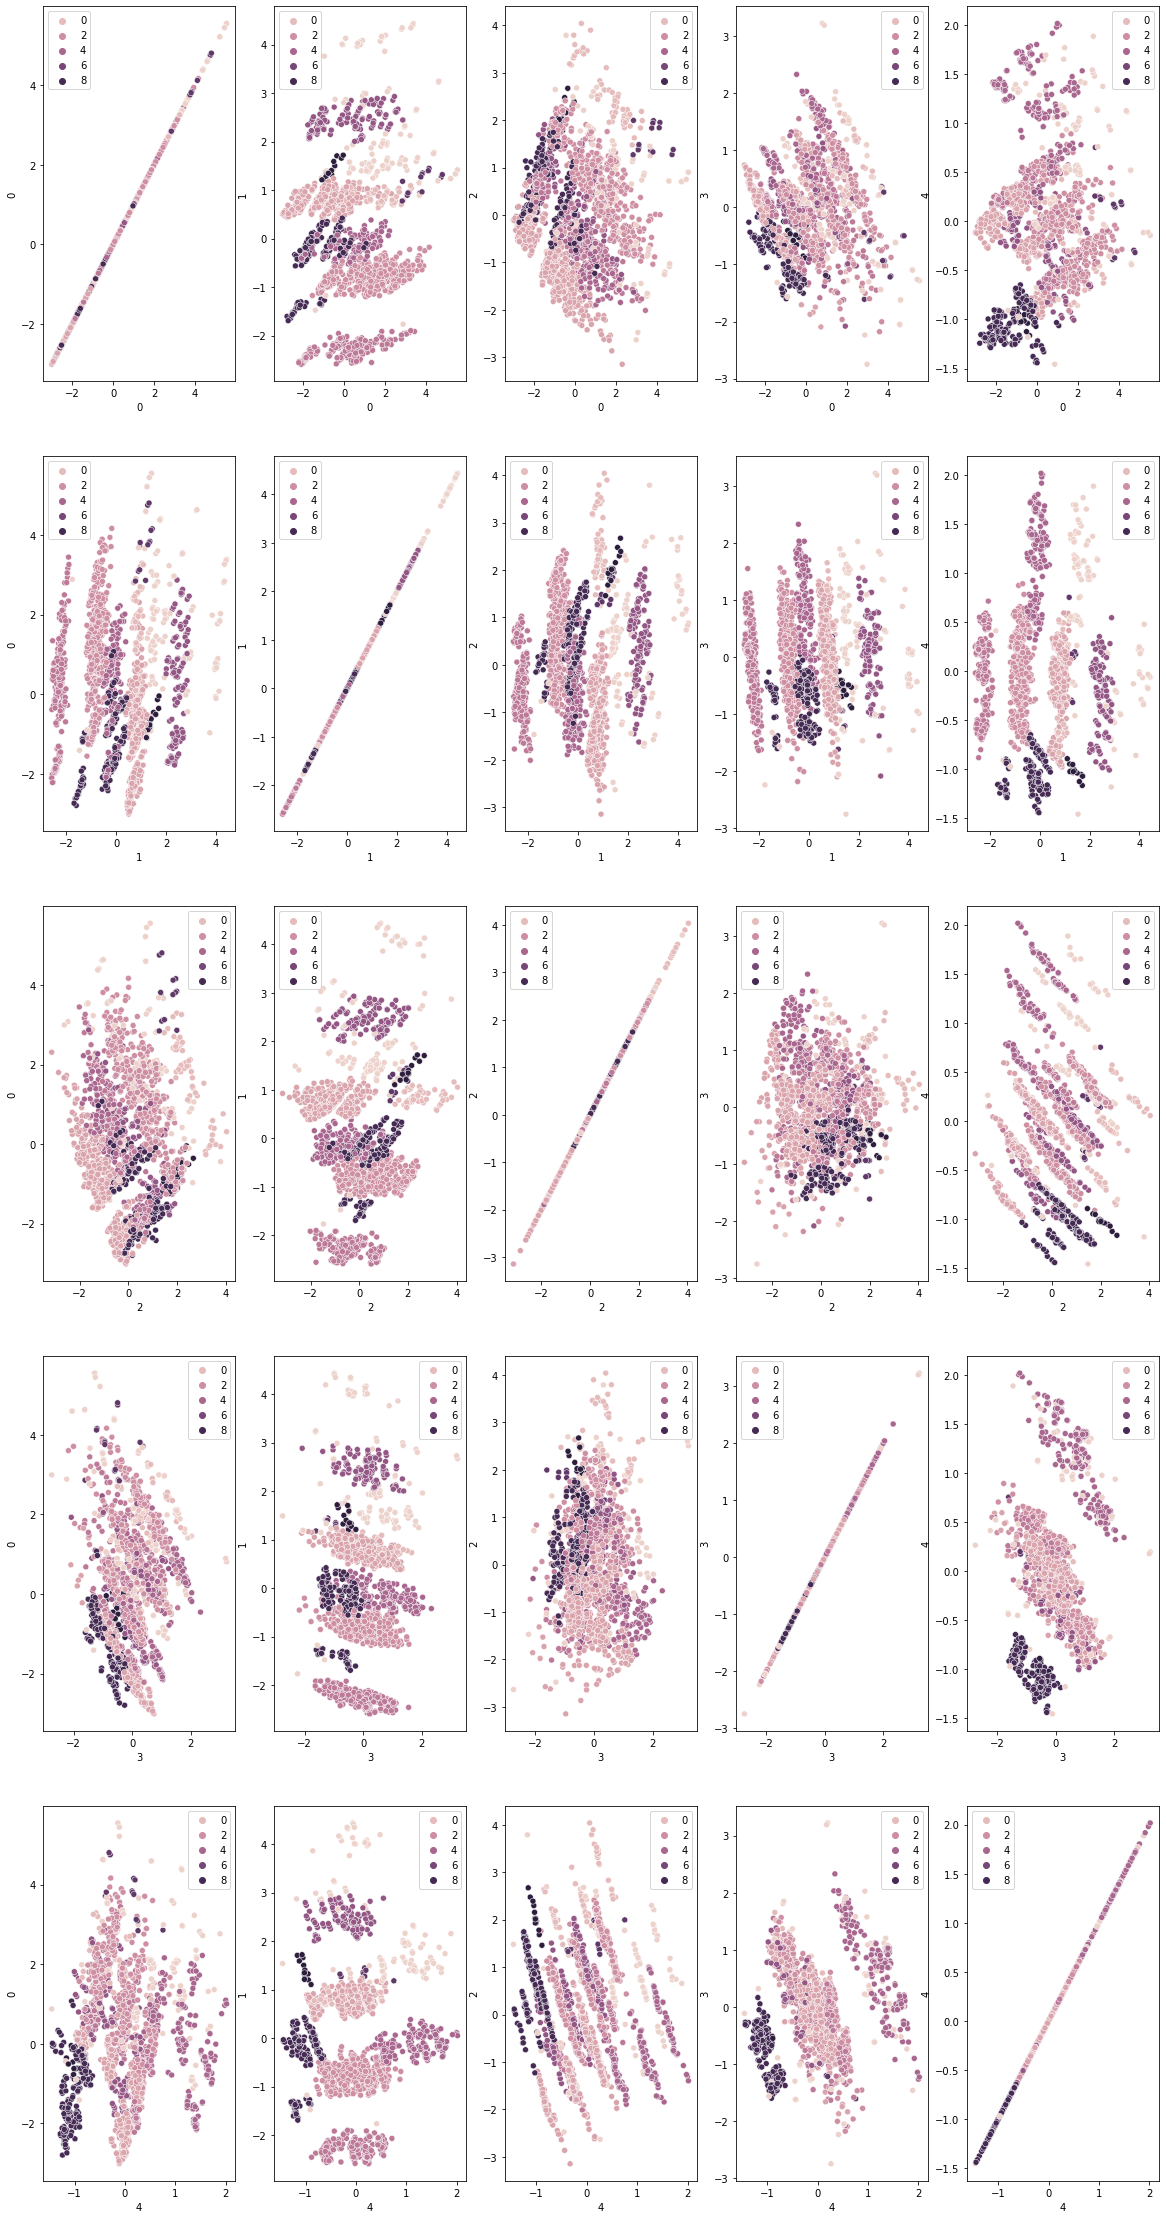

In [78]:
fig,ax=plt.subplots(5,5,figsize=(20,40))
for i in range(5):
    for j in range(5):
            sns.scatterplot(X_df[i],X_df[j],hue=clusters,ax=ax[i,j])